In [2]:
import pandas as pd
import numpy as np
import csv
import math
from sklearn.linear_model import PassiveAggressiveRegressor
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from datetime import datetime, timedelta
from pykrige.ok import OrdinaryKriging
from sklearn.metrics import mean_squared_error, mean_absolute_error
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
from sklearn.preprocessing import normalize
# import xgboost as xgb

import constants

In [3]:
with open("all_data_15_min.txt", "rb") as fp:   # Unpickling
    all_data = pickle.load(fp)

In [4]:
all_data[(all_data['lat_grid'] == 3) & (all_data['long_grid'] == 6)]

,PM1,PM2.5,PM10,temperature,humidity,lat,long,lat_grid,long_grid,hour,...,timestepContinuous,commercial,residential,green,primary,tertiary,unclassified,residential/service,pedestrian/cycle/noroad,prev_pm_2.5
6,0.560021,1.047775,1.250596,15.442787,81.600532,55.945433,-3.191392,3.0,6.0,0.000000,...,1.0,1,0,0,0,1,0,0,0,1.11201
12,0.594983,1.081502,1.236340,15.278152,82.272694,55.945433,-3.191392,3.0,6.0,0.000000,...,2.0,1,0,0,0,1,0,0,0,1.04777
18,0.572878,1.076748,1.264464,15.146444,83.280938,55.945433,-3.191392,3.0,6.0,0.000000,...,3.0,1,0,0,0,1,0,0,0,1.0815
24,0.634167,1.148729,1.332896,15.014736,83.785060,55.945433,-3.191392,3.0,6.0,0.333333,...,4.0,1,0,0,0,1,0,0,0,1.07675
30,0.530635,0.927738,1.023388,15.014736,83.785060,55.945433,-3.191392,3.0,6.0,1.000000,...,5.0,1,0,0,0,1,0,0,0,1.14873
36,0.534664,0.934954,1.006550,14.981809,84.087533,55.945433,-3.191392,3.0,6.0,1.000000,...,6.0,1,0,0,0,1,0,0,0,0.927738
42,0.504471,0.875966,0.930986,14.948881,83.986709,55.945433,-3.191392,3.0,6.0,1.000000,...,7.0,1,0,0,0,1,0,0,0,0.934954
48,0.565499,0.999668,1.159413,14.948881,83.583411,55.945433,-3.191392,3.0,6.0,1.333333,...,8.0,1,0,0,0,1,0,0,0,0.875966
54,0.485611,0.838667,1.280593,14.915954,83.549803,55.945433,-3.191392,3.0,6.0,2.000000,...,9.0,1,0,0,0,1,0,0,0,0.999668
60,0.477142,0.842633,1.000711,14.817173,83.280938,55.945433,-3.191392,3.0,6.0,2.000000,...,10.0,1,0,0,0,1,0,0,0,0.838667


In [33]:
def plot_preds(preds, labels):
#     hist = pd.DataFrame(history.history)
#     hist['epoch'] = history.epoch

    x = range(len(preds))
    plt.figure()
    plt.xlabel('Data Point')
    plt.ylabel('Value')
    plt.plot(x, preds,
           label='Feature')
    plt.plot(x, labels,
           label = 'True Value')
    plt.ylim([0,.1])
    plt.xlim([0, 1000])
    plt.legend()

    plt.show()

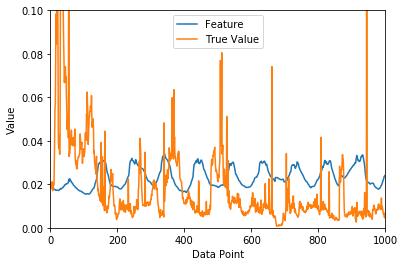

In [35]:
data = all_data[(all_data['lat_grid'] == 3) & (all_data['long_grid'] == 10)]
pm = np.array(data['PM2.5'])
pm = normalize(pm[:,np.newaxis], axis=0).ravel()
temp = np.array(data['temperature'])
temp = normalize(temp[:,np.newaxis], axis=0).ravel()
plot_preds(temp, pm)